In [121]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out


  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad #nx^n-1 * n (last n for chain rule)
    out._backward = _backward

    return out



  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self,other): #self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)



  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out




  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [123]:
#a=Value(2.0)
#a*1
#a.__mul__(2)

#2*a
#1.__mul__(a)

In [124]:
a = Value(2.0)
b = Value(4.0)


a-b

Value(data=-2.0)

In [125]:
"""
a=Value(5.00)
b=Value(2.00)

a/b
a * (1/b)
a * (b**-1)


"""

'\na=Value(5.00)\nb=Value(2.00)\n\na/b\na * (1/b)\na * (b**-1)\n\n\n'

In [126]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [127]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

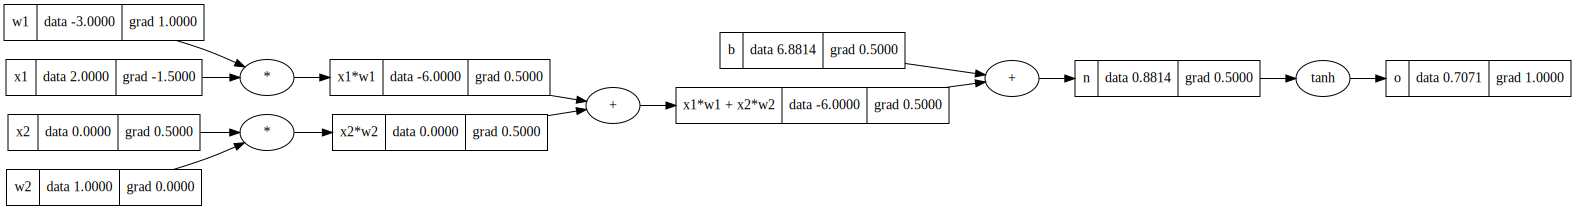

In [128]:
draw_dot(o)

break down the tanh

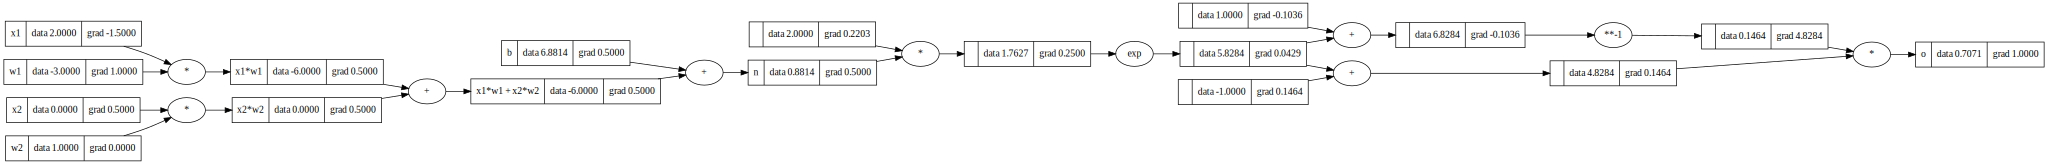

In [129]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#------------------------------
e = (2*n).exp()
o = (e-1)/(e+1)

#-------------------------------
o.label = 'o'
o.backward()
draw_dot(o)

**With pytorch**

In [130]:
import torch
import random

In [131]:
x1 = torch.Tensor([2.0]).double();                  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                 w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();    b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [132]:
class Neuron:

  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))


  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

#this Layer class represents a single layer in a neural network, where each layer consists of multiple neurons.
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)] # Create 'nout' neurons, each with 'nin' inputs

  def __call__(self, x):
    outs = [n(x) for n in self.neurons] # Pass input 'x' through each neuron
    return outs[0] if len(outs) == 1 else outs # Return the outputs from all neurons

  def parameters(self):
    param = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      param.extend(ps)
    return param
    #return [p for neuron in self.neurons for p in neuron.parameters()] # Return all parameters from all neurons

#It takes an input, passes it through multiple layers (each containing neurons), and returns the final output.
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts # List of layer sizes, including input and output sizes,sz ensures that each layer connects to the next.
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # Create layers

  def __call__(self, x):
    for layer in self.layers: # Pass input through each layer sequentially
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()] # Return all parameters from all layers


In [133]:
x = [2.0,3.0,-1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.9046236513652358)

In [134]:
n.parameters()

[Value(data=-0.18573006133351533),
 Value(data=-0.2683691516180684),
 Value(data=0.6201500246261931),
 Value(data=-0.8624763491960619),
 Value(data=-0.24021505869047988),
 Value(data=0.8150332162652247),
 Value(data=-0.6946868266850585),
 Value(data=0.6254193113123889),
 Value(data=0.5731894272481679),
 Value(data=-0.956700079287742),
 Value(data=-0.46059152540542336),
 Value(data=0.8464292133487044),
 Value(data=-0.1109696370225226),
 Value(data=0.7102108229441204),
 Value(data=-0.07739302056849007),
 Value(data=0.577712759803108),
 Value(data=0.08708959977710418),
 Value(data=0.12686734195078708),
 Value(data=-0.17021485662819313),
 Value(data=0.16727785926125316),
 Value(data=-0.6111650025728428),
 Value(data=0.29278893359487745),
 Value(data=-0.9957216908738713),
 Value(data=0.5798737990234231),
 Value(data=-0.6493908010319855),
 Value(data=0.3121948514523398),
 Value(data=0.11666302437513076),
 Value(data=0.45519468863042367),
 Value(data=-0.8254144542581094),
 Value(data=0.007641

In [135]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [145]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] ,Value(0.0))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)

0 0.004069776663196126
1 0.00406432966296379
2 0.004058896806137464
3 0.004053478038449641
4 0.004048073305907778
5 0.004042682554792619
6 0.004037305731656349
7 0.004031942783321007
8 0.004026593656876773
9 0.0040212582996802335
10 0.004015936659352792
11 0.004010628683778983
12 0.00400533432110484
13 0.004000053519736155
14 0.003994786228337108
15 0.003989532395828451
16 0.003984291971385938
17 0.003979064904438894
18 0.0039738511446684366
19 0.0039686506420060835


In [139]:

n.layers[0].neurons[0].w[0].grad

-0.0061063442020621575

In [ ]:
n.layers[0].neurons[0].w[0].data

In [ ]:
n.layers[0].neurons[0].w[0].data

In [ ]:
print(dir(n))  # Lists all attributes and methods of n